# Import libraries

Before the training,download the dataset from this link : https://drive.google.com/file/d/1HWtBaSa-LTyAMgf2uaz1T9o1sTWDBajU/view

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from patchify import patchify
import tifffile
from Unet_MultiClass_Model import UNET_MultiClass
from tqdm import tqdm
import glob
import os
import cv2
import random

# Decompose our tiff stacked images

In [11]:
# Read the stacked .tif image and mask
large_img_stack=tifffile.imread("sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/images_as_128x128_patches.tif")
large_mask_stack=tifffile.imread("sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/masks_as_128x128_patches.tif")

In [12]:
# There are 1600 images and masks with 128x128.
print(large_img_stack.shape)
print(large_mask_stack.shape)

(1600, 128, 128)
(1600, 128, 128)


In [13]:
# Decompose the stacked image 
for img in range(large_img_stack.shape[0]):
    large_img=large_img_stack[img]
    # Split the stacked image into 128x128 images (1600 images)
    patches_img=patchify(large_img,(128,128),step=128)
    # patches_img.shape --> (1,1,128,128)
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            
            single_patch_img=patches_img[i,j,:,:]
            # single_patch_img.shape --> (128,128)
            
            # Extract the single image 128x128 from stacked image and write into folder.
            tifffile.imwrite("sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/images/"+"img_"
                             +str(img)+"_"+str(i)+str(j)+".tif",single_patch_img)
            
print("DONE!")
            

DONE!


In [14]:
# Decompose the stacked mask
for img in range(large_mask_stack.shape[0]):
    large_mask=large_mask_stack[img]
    
    # Split the stacked image into 128x128 masks (1600 masks)
    patches_mask=patchify(large_mask,(128,128),step=128)
    # patches_mask.shape --> (1,1,128,128)
    
    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            
            # single_patch_mask.shape --> (128,128)
            single_patch_mask=patches_mask[i,j,:,:]
            
            # Extract the single image 128x128 from stacked image and write into folder.
            tifffile.imwrite("sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/masks/"+"mask_"
                             +str(img)+"_"+str(i)+str(j)+".tif",single_patch_mask)
            
print("DONE!")
            

DONE!


In [15]:
print(patches_img.shape)
print(patches_mask.shape)

(1, 1, 128, 128)
(1, 1, 128, 128)


# Extract all images to our lists

In [17]:
images_path="sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/images/"
masks_path="sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/masks/"

In [18]:
# Create the list.It keeps the arrays of the train images.
train_images=[]

# Go to the directory of each images
for directory_path in glob.glob(images_path):
    
    # Go to .tif files
    for img_path in tqdm(glob.glob(os.path.join(directory_path,"*.tif"))):
        # Read the image and append to the list
        img=cv2.imread(img_path,0)
        train_images.append(img)
        
train_images=np.array(train_images)
print("DONE!")

100%|█████████████████████████████████████████████████████████████████████████████| 1600/1600 [00:05<00:00, 299.47it/s]

DONE!


In [19]:
print("train_images.shape",train_images.shape)

train_images.shape (1600, 128, 128)


In [20]:
# Create the list.It keeps the arrays of the train images.
train_masks=[]

# Go to the directory of each masks
for directory_path in glob.glob(masks_path):
    
    # Go to .tif files
    for mask_path in tqdm(glob.glob(os.path.join(directory_path,"*.tif"))):
        # Read the image and append to the list
        mask=cv2.imread(mask_path,0)
        train_masks.append(mask)
    
train_masks=np.array(train_masks)
print("DONE!")

100%|█████████████████████████████████████████████████████████████████████████████| 1600/1600 [00:04<00:00, 353.04it/s]

DONE!


In [21]:
print("train_masks.shape",train_masks.shape)

train_masks.shape (1600, 128, 128)


In [22]:
np.unique(train_masks) 

array([1, 2, 3, 4], dtype=uint8)

# Encoding the mask values(labels)

In [23]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import normalize

In [39]:
# We have to encode the mask (1,2,3,4) --> (0,1,2,3)

lbe=LabelEncoder()
n,h,w=train_masks.shape
train_masks_reshaped=train_masks.reshape(-1,1) # Flatten the labels (1600*128*128,1)
train_masks_reshaped_encoded=lbe.fit_transform(train_masks_reshaped) # Encode the labels (0,1,2,3)
train_masks_encoded_original_shape=train_masks_reshaped_encoded.reshape(n,h,w) # Reshape old shape (1600,128,128)

print(np.unique(train_masks_encoded_original_shape))
print(train_masks_encoded_original_shape.shape)


[0 1 2 3]
(1600, 128, 128)


In [25]:
print(train_masks_input.shape)

(1600, 128, 128)


In [26]:
# The model wants to inputs as 4-dimensional
train_images=np.expand_dims(train_images,axis=3)
train_images=normalize(train_images,axis=1) #Apply the normalization

print(train_images.shape)

(1600, 128, 128, 1)


In [40]:
# Expand 4th dimension to feed the model because the model wants data with 4 dimension.
train_masks_input=np.expand_dims(train_masks_encoded_original_shape,axis=3)
print(train_masks_input.shape)

(1600, 128, 128, 1)


# Split train and test dataset

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
X_train,X_test,Y_train,Y_test=train_test_split(train_images,train_masks_input,
                                               test_size=0.2,random_state=42)

In [44]:
print("X_train.shape",X_train.shape)
print("Y_train.shape",Y_train.shape)
print("X_test.shape",X_test.shape)
print("Y_test.shape",Y_test.shape)

X_train.shape (1280, 128, 128, 1)
Y_train.shape (1280, 128, 128, 1)
X_test.shape (320, 128, 128, 1)
Y_test.shape (320, 128, 128, 1)


# Categorize the labels

In [46]:
from keras.utils import to_categorical

In [47]:
# Convert the labels into one-hot-encoded type
# Each pixel value will be defined by one-hot-encoded label.

train_masks_cat=to_categorical(Y_train,num_classes=n_classes)
print(train_masks_cat.shape)

Y_train_cat=train_masks_cat.reshape((Y_train.shape[0],Y_train.shape[1],Y_train.shape[2],n_classes))
print(Y_train_cat.shape)

(1280, 128, 128, 4)
(1280, 128, 128, 4)


In [60]:
test_masks_cat=to_categorical(Y_test,num_classes=n_classes)
print(test_masks_cat.shape)

Y_test_cat=test_masks_cat.reshape((Y_test.shape[0],Y_test.shape[1],Y_test.shape[2],n_classes))
print(Y_test_cat.shape)

(320, 128, 128, 4)
(320, 128, 128, 4)


In [53]:
Y_train_cat

array([[[[0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         ...,
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.]],

        [[0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         ...,
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.]],

        [[0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         ...,
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.]],

        ...,

        [[1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         ...,
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.]],

        [[1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         ...,
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.]],

        [[1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         ...,
 

In [54]:
Y_train

array([[[[2],
         [2],
         [2],
         ...,
         [2],
         [2],
         [2]],

        [[2],
         [2],
         [2],
         ...,
         [2],
         [2],
         [2]],

        [[2],
         [2],
         [2],
         ...,
         [2],
         [2],
         [2]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [1],
         [1],
         [1]],

        [[0],
         [0],
         [0],
         ...,
         [1],
         [1],
         [1]],

        [[0],
         [0],
         [0],
         ...,
         [1],
         [1],
         [1]]],


       [[[2],
         [2],
         [2],
         ...,
         [2],
         [2],
         [2]],

        [[2],
         [2],
         [2],
         ...,
         [2],
         [2],
         [2]],

        [[2],
         [2],
         [2],
         ...,
         [2],
         [2],
         [2]],

        ...,

        [[2],
         [2],
         [2],
         ...,
         [0],


# Define the parameters

In [59]:
num_train,IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS=X_train.shape # Defining image height,width and number of channels.
BATCH_SIZE=16 # How many data will be taken in one epoch.
n_classes=4 # Number of classes for segmentation.

# Call UNet Model

In [58]:
model=UNET_MultiClass(n_classes=4,IMG_HEIGHT=IMG_HEIGHT,IMG_WIDTH=IMG_WIDTH
                      ,IMG_CHANNELS=IMG_CHANNELS)

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

# Training the Model

In [64]:
history=model.fit(X_train,Y_train_cat,batch_size=BATCH_SIZE,verbose=1,
                 epochs=30,validation_data=(X_test,Y_test_cat))

Epoch 1/30
80/80 [==============================] - 105s 1s/step - loss: 0.8650 - accuracy: 0.7570 - val_loss: 0.7797 - val_accuracy: 0.7661
Epoch 2/30
80/80 [==============================] - 100s 1s/step - loss: 0.7805 - accuracy: 0.7616 - val_loss: 0.7607 - val_accuracy: 0.7661
Epoch 3/30
80/80 [==============================] - 101s 1s/step - loss: 0.7590 - accuracy: 0.7616 - val_loss: 0.7257 - val_accuracy: 0.7661
Epoch 4/30
80/80 [==============================] - 100s 1s/step - loss: 0.7669 - accuracy: 0.7618 - val_loss: 0.7602 - val_accuracy: 0.7661
Epoch 5/30
80/80 [==============================] - 100s 1s/step - loss: 0.7699 - accuracy: 0.7616 - val_loss: 0.7583 - val_accuracy: 0.7661
Epoch 6/30
80/80 [==============================] - 100s 1s/step - loss: 0.7275 - accuracy: 0.7618 - val_loss: 0.7634 - val_accuracy: 0.8097
Epoch 7/30
80/80 [==============================] - 100s 1s/step - loss: 0.5495 - accuracy: 0.8356 - val_loss: 0.4635 - val_accuracy: 0.8506
Epoch 8/30
80

# Saving the Model and Weights

In [65]:
model.save("sandstone model/Unet_Multiclass_Model.h5")

# Saved model weights.
model.save_weights("sandstone model/Unet_MultiClass_Weights.h5")
print("Saved!")

Saved!


# Plotting the results

In [67]:
train_acc=history.history['accuracy']
train_loss=history.history['loss']
test_acc=history.history['val_accuracy']
test_loss=history.history['val_loss']

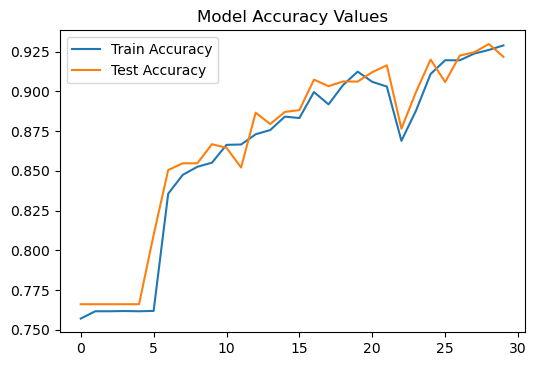

In [68]:
plt.figure(dpi=100)
plt.plot(train_acc,label="Train Accuracy")
plt.plot(test_acc,label="Test Accuracy")
plt.title("Model Accuracy Values")
plt.legend()
plt.show()

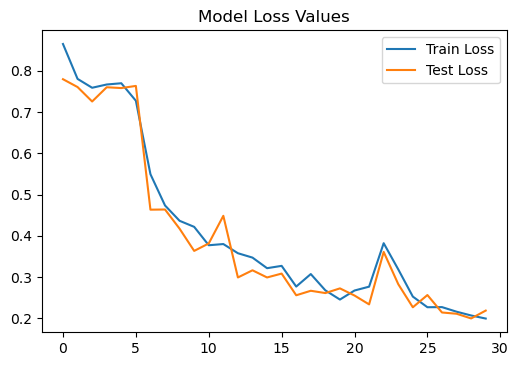

In [69]:
plt.figure(dpi=100)
plt.plot(train_loss,label="Train Loss")
plt.plot(test_loss,label="Test Loss")
plt.title("Model Loss Values")
plt.legend()
plt.show()

In [74]:
model.evaluate(X_test,Y_test_cat)

10/10 [==============================] - 4s 339ms/step - loss: 0.2190 - accuracy: 0.9218


[0.21895185112953186, 0.9218107461929321]

# Predict any image

In [234]:
# Choose random number
rand_num=random.randint(0,len(X_test))
print("random num:",rand_num)

# Choose random test image and mask(label)
test_img=X_test[rand_num]
print(test_img.shape)
test_img_label=Y_test[rand_num]

# Convert 4-dimensional to test image for prediction
test_img_norm=test_img[:,:,0][:,:,None]
print("test_img_norm.shape",test_img_norm.shape)
test_img_input=np.expand_dims(test_img_norm,axis=0)
print("test_img_input.shape",test_img_input.shape)

prediction=model.predict(test_img_input)
print("prediction.shape",prediction.shape)
predicted_img=np.argmax(prediction,axis=3)[0,:,:] # Get the index of max values for 4th dimension.
print("predicted_img.shape",predicted_img.shape)


random num: 48
(128, 128, 1)
test_img_norm.shape (128, 128, 1)
test_img_input.shape (1, 128, 128, 1)
1/1 [==============================] - 0s 31ms/step
prediction.shape (1, 128, 128, 4)
predicted_img.shape (128, 128)


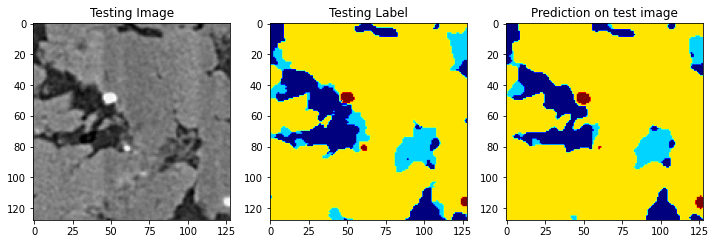

In [235]:
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img,cmap='gray')

plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_img_label,cmap="jet")

plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img,cmap='jet')

plt.show()

In [165]:
prediction[:,0,0] #0.kategoriye daha yakın olaslıkta.

array([[0.4771964 , 0.33909953, 0.18195824, 0.0017458 ]], dtype=float32)

In [219]:
predicted_img

array([[0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=int64)

In [217]:
np.argmax(prediction,axis=-1)[:,0,0]

array([0], dtype=int64)